In [1]:
# Third-party
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('notebook.mplstyle')
%matplotlib inline
import corner
import emcee
from scipy.integrate import quad

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

In [2]:
colors = ['#3182bd', '#de2d26']
gc_frame = coord.Galactocentric(z_sun=0*u.pc)
vlsr = [11.1, 12., 7.25] * u.km/u.s
vcirc = 220 * u.km/u.s

In [3]:
tgas = Table.read('../../gaia-wide-binaries/data/stacked_tgas.fits')
ID_tbl = Table.read('../../GaiaPairsFollowup/data/star_identifier.csv')

In [4]:
star1_idx = ID_tbl[ID_tbl['name'] == 'TYC 4013-1381-1']['tgas_row']
star2_idx = ID_tbl[ID_tbl['name'] == 'TYC 4013-763-1']['tgas_row']

star1_tgas = tgas[star1_idx[0]]
star2_tgas = tgas[star2_idx[0]]

In [5]:
star1_idx, star2_idx

(<Column name='tgas_row' dtype='int64' length=1>
 526395, <Column name='tgas_row' dtype='int64' length=1>
 526396)

In [6]:
rows = [star1_tgas, star2_tgas]

In [7]:
def get_cov(row, names=['parallax', 'pmra', 'pmdec']):
    C = np.zeros((len(names), len(names)))

    # pre-load the diagonal
    for i,name in enumerate(names):
        full_name = "{}_error".format(name)
        C[i,i] = row[full_name]**2

    for i,name1 in enumerate(names):
        for j,name2 in enumerate(names):
            if j <= i:
                continue
            full_name = "{}_{}_corr".format(name1, name2)
            C[i,j] = row[full_name] * np.sqrt(C[i,i]*C[j,j])
            C[j,i] = row[full_name] * np.sqrt(C[i,i]*C[j,j])
            
    return C

In [8]:
# skyc1, xyz1, vxyz1 = get_samples(star1_tgas, galactocentric_frame=gc_frame, vlsr=vlsr, size=100000)
# skyc2, xyz2, vxyz2 = get_samples(star2_tgas, galactocentric_frame=gc_frame, vlsr=vlsr, size=100000)

# Posterior predictions

In [9]:
class ProbModel(object):
    
    def __init__(self, skycoord, parallax, pm, rv, Cov, sigma_v=15.):
        """ 
        We store the data as attributes of the object so we don't have to 
        keep passing it in to the methods that compute the probabilities.
        """
        
        self.ra = np.asarray(skycoord.ra.radian)
        self.dec = np.asarray(skycoord.dec.radian)
        self.parallax = parallax.to(u.mas).value # 1000/r (r in pc) = parallax
        self.pm_ra = pm[0].to(u.mas/u.year).value # multiply by 4.7404705E-3 to get km/s
        self.pm_dec = pm[1].to(u.mas/u.year).value
        self.rv = rv.to(u.km/u.s).value
        
        self.Cinv = np.linalg.inv(Cov)
        
        self.sigma_v = sigma_v # km/s

    def ln_likelihood(self, pars):
        r, v_ra, v_dec, rv = pars
        # pc, km/s, km/s, km/s
        
        y = np.array([self.parallax, self.pm_ra, self.pm_dec, self.rv])
        y_hat = np.array([1000./r, 210.94953*v_ra/r, 210.94953*v_dec/r, rv])
        
        dy = (y - y_hat)
        _,det_Cinv = np.linalg.slogdet(self.Cinv/(2*np.pi))
        return 0.5 * det_Cinv - 0.5 * (dy.T @ self.Cinv @ dy)

    def ln_prior(self, pars):
        r, v_ra, v_dec, rv = pars
        # pc, km/s, km/s, km/s
        
        lp = 0.
        
        v = np.array([v_ra, v_dec, rv])
        lp += -0.5 * np.sum(v**2 / self.sigma_v**2)
        
        r_lim = 300. # pc
        if r > r_lim:
            return -np.inf
        lp += np.log(3/r_lim**3) + 2*np.log(r)
        
        return lp
        
    def ln_posterior(self, pars):
        """ 
        Up to a normalization constant, the log of the posterior pdf is just 
        the sum of the log likelihood plus the log prior.
        """
        lnp = self.ln_prior(pars)
        if np.isinf(lnp): # short-circuit if the prior is infinite (don't bother computing likelihood)
            return lnp

        lnL = self.ln_likelihood(pars).sum()
        lnprob = lnp + lnL

        if np.isnan(lnprob):
            return -np.inf

        return lnprob
    
    def __call__(self, pars):
        return self.ln_posterior(pars)

In [10]:
rv = -21.2 * u.km/u.s
rv_err = 0.2 * u.km/u.s

In [11]:
nwalkers = 32

flatchains = []
for row in [star1_tgas, star2_tgas]:
    Cov = np.zeros((4,4))
    Cov[:3,:3] = get_cov(row, names=['parallax', 'pmra', 'pmdec'])
    Cov[3,3] = rv_err.to(u.km/u.s).value**2

    skyc = coord.SkyCoord(ra=row['ra']*u.deg, dec=row['dec']*u.deg)
                          
    pm = [row['pmra'], row['pmdec']]*u.mas/u.yr
    model = ProbModel(skyc, row['parallax']*u.mas, 
                      pm, rv, Cov, sigma_v=25.)

    _d = 1000./row['parallax']
    p0 = np.array([_d, (pm[0]*_d*u.pc).to(u.km/u.s, u.dimensionless_angles()).value, 
                   (pm[1]*_d*u.pc).to(u.km/u.s, u.dimensionless_angles()).value, rv.value])

    ndim = len(p0)
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=model)

    p0s = emcee.utils.sample_ball(p0, std=1E-5*p0, size=nwalkers)

    pos,_,_ = sampler.run_mcmc(p0s, 512)
    sampler.reset()
    pos,_,_ = sampler.run_mcmc(pos, 4096)
    
    flatchains.append(sampler.flatchain)

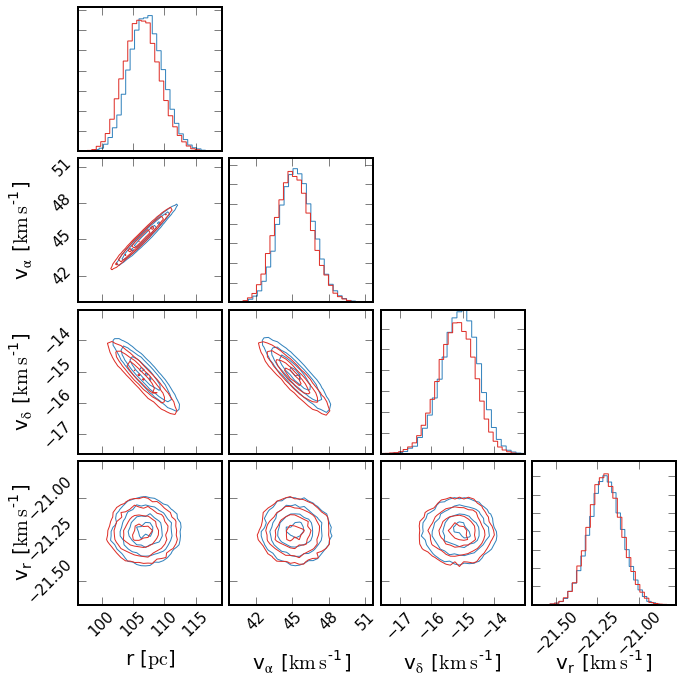

In [17]:
labels = [r'$r$ [${\rm pc}$]',
          r'$v_\alpha$ [${\rm km}\,{\rm s}^{-1}$]',
          r'$v_\delta$ [${\rm km}\,{\rm s}^{-1}$]',
          r'$v_r$ [${\rm km}\,{\rm s}^{-1}$]']

kwargs = dict(bins=32, labels=labels, plot_density=False, plot_datapoints=False, alpha=0.5)

fig = None
for flatchain, color in zip(flatchains, ['#3182bd', '#de2d26']):
    # dist, v_ra, v_dec, rvs = flatchain.T
    
    if fig is None:
        fig = corner.corner(flatchain, color=color, **kwargs)
    else:
        fig = corner.corner(flatchain, color=color, fig=fig, **kwargs)
        
fig.set_facecolor('w')

In [12]:
ws = []
for color, flatchain, row in zip(colors, flatchains, rows):
    dist, v_ra, v_dec, rvs = flatchain.T
    skyc = coord.SkyCoord(ra=row['ra']*u.deg, dec=row['dec']*u.deg,
                          distance=dist*u.pc)
    
    _pm = ([v_ra, v_dec]*u.km/u.s / (dist*u.pc)).to(u.mas/u.yr, u.dimensionless_angles())
    
    xyz = skyc.transform_to(gc_frame).cartesian.xyz.to(u.pc).value
    vxyz = gc.vhel_to_gal(skyc, _pm, rvs*u.km/u.s, vlsr=vlsr, 
                          galactocentric_frame=gc_frame).to(u.km/u.s).value
    ws.append(np.vstack((xyz, vxyz)).T)

In [37]:
# corner.hist2d()

In [13]:
dw = ws[0]-ws[1]
dxv=np.vstack([dw[:,:3].sum(axis=1), dw[:,3:].sum(axis=1)]).T

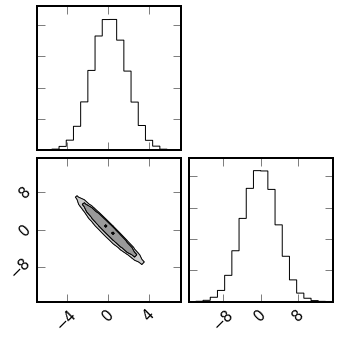

In [39]:
# truth_color = '#31a354'
# ranges = [(-8.5,8.5), (-12,12), (-1,1), (-7,7), (-7,7), (-7,7)]
# bins = [np.linspace(x1,x2,128) for x1,x2 in ranges]
# labels = [r'$\Delta x$ [${\sf pc}$]',
#           r'$\Delta y$ [${\sf pc}$]',
#           r'$\Delta z$ [${\sf pc}$]',
#           r'$\Delta v_x$ [${\sf km}\,{\sf s}^{-1}$]',
#           r'$\Delta v_y$ [${\sf km}\,{\sf s}^{-1}$]',
#           r'$\Delta v_z$ [${\sf km}\,{\sf s}^{-1}$]']

fig = corner.corner(dxv, plot_density=False, 
                    plot_datapoints=False, fill_contours=True, label_kwargs=dict(size=20))

# for i in range(6):
#     for j in range(6):
#         if j > i: 
#             continue

#         fig.axes[6*i+j].axvline(0., color=truth_color, alpha=0.5, zorder=10)
#         if i > j:
#             fig.axes[6*i+j].axhline(0., color=truth_color, alpha=0.5, zorder=10)
#             fig.axes[6*i+j].scatter(0., 0., color=truth_color, marker='s', s=5, zorder=100)

# fig.set_facecolor('w')
# fig.savefig('../paper/figures/dx_dv_posterior.pdf')

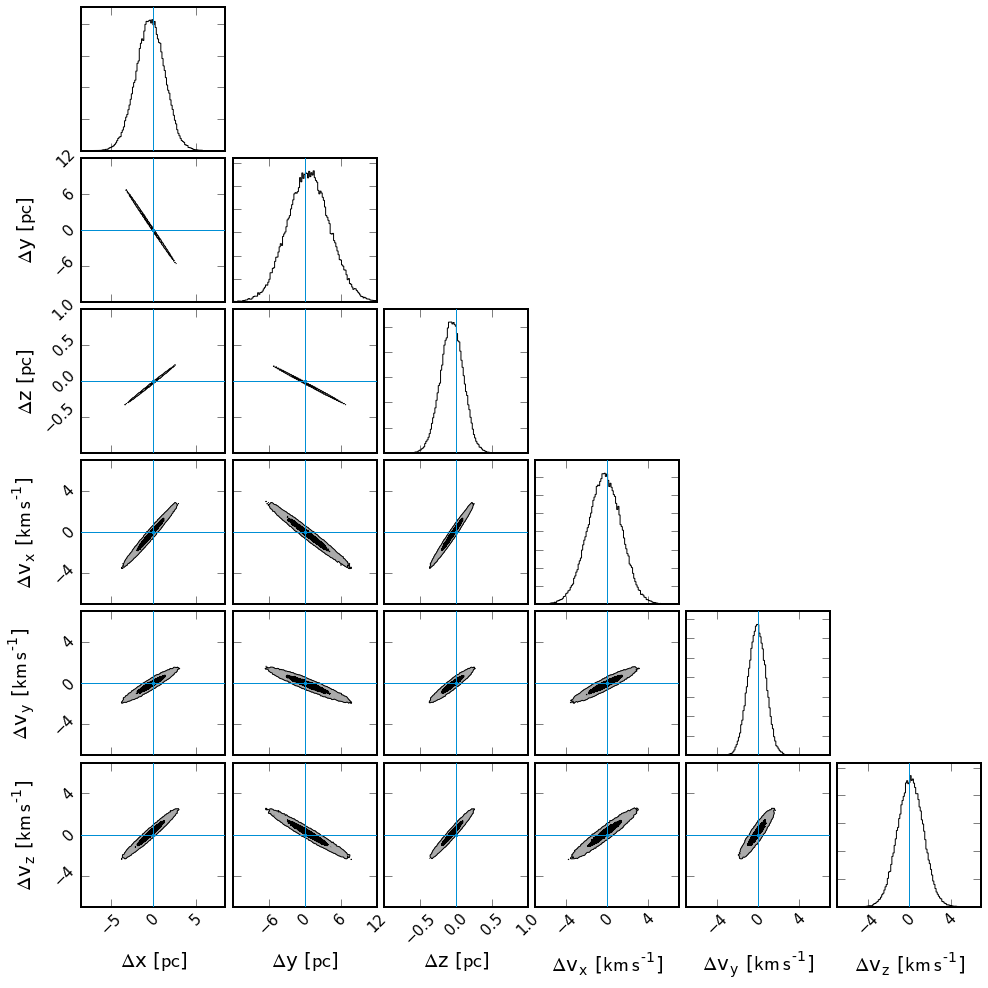

In [14]:
truth_color = '#008fd5'
ranges = [(-8.5,8.5), (-12,12), (-1,1), (-7,7), (-7,7), (-7,7)]
bins = [np.linspace(x1,x2,128) for x1,x2 in ranges]
labels = [r'$\Delta x$ [${\sf pc}$]',
          r'$\Delta y$ [${\sf pc}$]',
          r'$\Delta z$ [${\sf pc}$]',
          r'$\Delta v_x$ [${\sf km}\,{\sf s}^{-1}$]',
          r'$\Delta v_y$ [${\sf km}\,{\sf s}^{-1}$]',
          r'$\Delta v_z$ [${\sf km}\,{\sf s}^{-1}$]']

fig = corner.corner(ws[0]-ws[1], bins=bins, plot_density=False, 
                    plot_datapoints=False, fill_contours=True, labels=labels,
                    levels=(1-np.exp(-0.5),1-np.exp(-2)), range=ranges, label_kwargs=dict(size=20))

for i in range(6):
    for j in range(6):
        if j > i: 
            continue

        fig.axes[6*i+j].axvline(0., color=truth_color, zorder=10)
        if i > j:
            fig.axes[6*i+j].axhline(0., color=truth_color, zorder=10)
            fig.axes[6*i+j].scatter(0., 0., color=truth_color, marker='s', s=7, zorder=100)

# fig.set_facecolor('w')
fig.savefig('../paper/figures/dx_dv_posterior.pdf')

# Integrate orbits

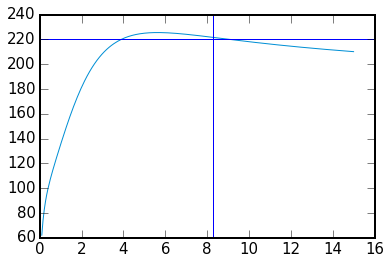

In [15]:
mw_potential = gp.CCompositePotential()
mw_potential['spheroid'] = gp.HernquistPotential(m=5E9, c=0.7, units=galactic)
mw_potential['halo'] = gp.NFWPotential(m=5E11*u.Msun, r_s=16., units=galactic)
mw_potential['disk1'] = gp.MiyamotoNagaiPotential(m=6.5E10*u.Msun, a=3, b=0.273,
                                                  units=galactic)
# mw_potential['disk2'] = gp.MiyamotoNagaiPotential(m=1.0E10*u.Msun, a=3.5, b=0.15,
#                                                   units=galactic)

_xyzs = np.zeros((3,256))
_xyzs[0] = np.linspace(0.1, 15., _xyzs.shape[1])

plt.plot(_xyzs[0], mw_potential.circular_velocity(_xyzs), marker='')
plt.axvline(8.3)
plt.axhline(220)

In [16]:
# from galpy.potential import MWPotential2014
# from galpy.potential import evaluateDensities
# from galpy.util import bovy_conversion
# from galpy.orbit import Orbit

# R = 4
# zs = np.linspace(-1., 1., 256)
# dens = evaluateDensities(MWPotential2014, np.full(256, R)*u.kpc, zs*u.kpc)
# plt.plot(zs, dens*bovy_conversion.dens_in_msolpc3(220.,8.))

# _xyz = np.zeros((3,len(zs)))
# _xyz[0] = R
# _xyz[2] = zs
# dens2 = mw_potential.density(_xyz)
# plt.plot(zs, dens2.to(u.Msun/u.pc**3))

# o = Orbit(vxvv=[8.*u.kpc, 22.*u.km/u.s,242.*u.km/u.s, 0.*u.pc,20.*u.km/u.s])
# ts = np.linspace(0,100,10000)
# o.integrate(ts, MWPotential2014, method='odeint')
# o.plot()

In [17]:
HD_orbits = []
for w in ws:
    w = np.median(w, axis=0)    
    w0 = gd.CartesianPhaseSpacePosition(pos=w[:3] * u.pc,
                                        vel=w[3:] * u.km/u.s)

    orbit = mw_potential.integrate_orbit(w0, dt=-0.5, n_steps=5000, 
                                         Integrator=gi.DOPRI853Integrator)
    HD_orbits.append(orbit)
    
cyl,vcyl = orbit.represent_as(coord.CylindricalRepresentation)    

(0.7568607178256439, 100)

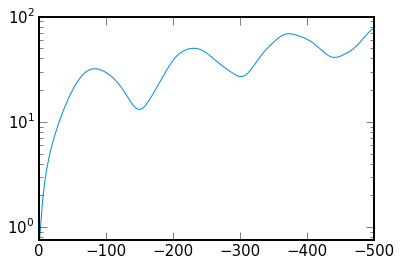

In [18]:
dr = np.sqrt(np.sum((HD_orbits[1].pos - HD_orbits[0].pos)**2, axis=0)).to(u.pc)
plt.plot(HD_orbits[0].t, dr)
plt.yscale('log')
plt.xlim(0, -500)
plt.ylim(0, 100)

In [19]:
sun_w0 = gd.CartesianPhaseSpacePosition(pos=[-8.3, 0, 0] * u.kpc,
                                        vel=vlsr + [0, vcirc.to(u.km/u.s).value, 0.]*u.km/u.s)

sun_orbit = mw_potential.integrate_orbit(sun_w0, dt=0.5, n_steps=5000, 
                                         Integrator=gi.DOPRI853Integrator)

sun_cyl,_ = sun_orbit.represent_as(coord.CylindricalRepresentation)

In [20]:
many_HD_orbits = []
for w in ws:
    idx = np.random.choice(len(w), size=1024, replace=False)
    w = w[idx].T
    w0 = gd.CartesianPhaseSpacePosition(pos=w[:3] * u.pc,
                                        vel=w[3:] * u.km/u.s)

    orbit = mw_potential.integrate_orbit(w0, dt=-1, n_steps=500, 
                                         Integrator=gi.DOPRI853Integrator)
    many_HD_orbits.append(orbit)

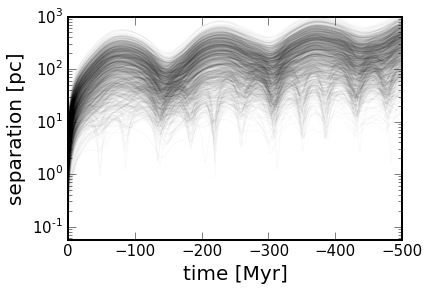

In [21]:
dr = np.sqrt(np.sum((many_HD_orbits[1].pos - many_HD_orbits[0].pos)**2, axis=0)).to(u.pc)
plt.plot(many_HD_orbits[0].t, dr, marker='', alpha=0.025, color='k')
plt.yscale('log')
plt.xlim(0, -500)
plt.ylim(0, 1000)
plt.xlabel('time [Myr]')
plt.ylabel('separation [pc]')

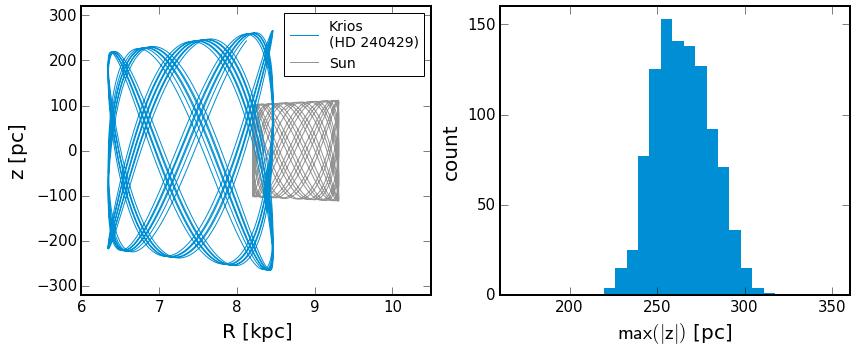

In [22]:
fig,axes = plt.subplots(1, 2, figsize=(12,5))

ax = axes[0]
ax.plot(cyl.rho, cyl.z.to(u.pc), marker='', 
        label='Krios\n(HD 240429)')
ax.plot(sun_cyl.rho, sun_cyl.z.to(u.pc), marker='',
        color='#666666', alpha=0.7, zorder=-10, label='Sun')
ax.set_xlim(6.7, 10.5)
ax.set_xticks([6.,7., 8., 9., 10.])
ax.set_ylim(-320, 320)

ax.legend(loc='upper right', fontsize=14)
ax.set_xlabel('$R$ [kpc]')
ax.set_ylabel('$z$ [pc]')

ax = axes[1]
ax.hist(np.max(np.abs(many_HD_orbits[0].pos[2]), axis=0).to(u.pc).value, bins=np.linspace(200,350,24))
ax.set_xlim(160, 360)
ax.set_yticks([0., 50, 100, 150])
ax.set_xlabel(r'$\sf max\left(|z|\right)$ [pc]')
ax.set_ylabel('count')

fig.tight_layout()

fig.savefig('../paper/figures/orbits.pdf')

In [ ]:
# labels = [r'$r$ [${\rm pc}$]',
#           r'$v_\alpha$ [${\rm km}\,{\rm s}^{-1}$]',
#           r'$v_\delta$ [${\rm km}\,{\rm s}^{-1}$]',
#           r'$v_r$ [${\rm km}\,{\rm s}^{-1}$]']

# kwargs = dict(bins=32, labels=labels, plot_density=False, plot_datapoints=False, alpha=0.5)

# fig = None
# for flatchain, color in zip(flatchains, ['#3182bd', '#de2d26']):
# #     dist, v_ra, v_dec, rvs = flatchain.T
    
#     if fig is None:
#         fig = corner.corner(flatchain, color=color, **kwargs)
#     else:
#         fig = corner.corner(flatchain, color=color, fig=fig, **kwargs)
        
# fig.set_facecolor('w')